Imports

In [60]:
from bs4 import BeautifulSoup
import requests
import time, os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

chromedriver = "/usr/bin/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

Request Info

In [2]:
url = 'https://www.boxofficemojo.com/title/tt7286456/'
response = requests.get(url)
page = response.text

soup = BeautifulSoup(page, 'html5lib')


Money to int, runtime to minutes, date to datestring function 

In [3]:
import dateutil.parser

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    if type(runtimestring) != 'NoneType':
        runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [4]:
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

In [5]:
def get_movie_dict(link):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
        - title 
        - domestic gross
        - runtime 
        - MPAA rating
        - full release date
    Return information as a dictionary.
    '''
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title', 'domestic_total_gross',
               'runtime_minutes', 'rating', 'release_date', 'budget']
    
    #Get title
    title_string = soup.find('title').text
    title = title_string.split('-')[0].strip()
    #Get domestic gross
    try:
        raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    except:
        raw_domestic_total_gross = float("NaN")
    
    if type(raw_domestic_total_gross) == float or type(raw_domestic_total_gross) == 'NoneType':
        print('This is a NaN')
        domestic_total_gross = float("NaN")
    else:
        domestic_total_gross = money_to_int(raw_domestic_total_gross)

    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    if type(raw_runtime) != float and type(raw_runtime) != 'NoneType':
        runtime = runtime_to_minutes(raw_runtime)
    
    #Get rating
    rating = get_movie_value(soup,'MPAA')

    #Get release date
    if '-' in get_movie_value(soup, 'Release Date'):
        raw_release_date = get_movie_value(soup,'Release Date').split('-')[0]
    elif '(' in get_movie_value(soup, 'Release Date'):
        raw_release_date = get_movie_value(soup,'Release Date').split('(')[0]
    else:
        raw_release_date = get_movie_value(soup,'Release Date').split('(')[0]
    release_date = to_date(raw_release_date)
    
    # Get budget
    budget = soup.find(class_='mojo-summary-values')
    answer = []
    money = budget.find_all(class_='money')
    for m in money:
        answer.append(m) 
    budget = answer[-1].text
    if type(budget) != float and type(budget) != 'NoneType':
        budget = money_to_int(budget)
    
    #Create movie dictionary and return
    movie_dict = dict(zip(headers,[title,
                                domestic_total_gross,
                                runtime,
                                rating, 
                                release_date,
                                budget]))

    return movie_dict

In [6]:
links = [ 
        'rl1182631425',
        'rl2969994753',
        'rl4244997633',
        'rl755467777',
        'rl3305145857',
        'rl3640886785',
        'rl2164295169',
        'rl218596865',
        'rl50628097',
        'rl2533524993',
        'rl3433267713',
        'rl3204875777',
        'rl2424210945',
        'rl1333691905',
        'rl3473442305',
        'rl419792385',
        'rl1258849793',
        'rl1611040257',
        'rl3825763841',
        'rl4278486529',
        'rl1745126913',
        'rl1655931393',
        'rl302548481',
        'rl3020195329',
        'rl3842541057',
        'rl867926529',
        'rl2550760961',
        'rl4127819265',
        'rl2567538177',
        'rl2030601729',
        'rl2998501889',
        'rl990348801',
        'rl3221784065',
        'rl235374081',
        'rl1628014081',
        'rl2611249665',
        'rl3669066241',
        'rl2684847617',
        'rl1459979777',
        'rl3775038977',
        'rl2651096577',
        'rl2903213569',
        'rl1325958657',
        'rl50824705',
        'rl537298433',
        'rl1617987073',
        'rl1386316289',
        'rl716997121',
        'rl252151297'
        ]

dicts = []

for link in links:
    dicts.append(get_movie_dict('/release/{}/'.format(link)))

dicts

[{'movie_title': 'Bad Boys for Life',
  'domestic_total_gross': 204417855,
  'runtime_minutes': 124,
  'rating': 'R',
  'release_date': datetime.datetime(2020, 1, 17, 0, 0),
  'budget': 90000000},
 {'movie_title': '1917',
  'domestic_total_gross': 159227644,
  'runtime_minutes': 119,
  'rating': 'R',
  'release_date': datetime.datetime(2019, 12, 25, 0, 0),
  'budget': 95000000},
 {'movie_title': 'Sonic the Hedgehog',
  'domestic_total_gross': 146066470,
  'runtime_minutes': 99,
  'rating': 'PG',
  'release_date': datetime.datetime(2020, 2, 14, 0, 0),
  'budget': 85000000},
 {'movie_title': 'Jumanji: The Next Level',
  'domestic_total_gross': 316831246,
  'runtime_minutes': 123,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2019, 12, 13, 0, 0),
  'budget': 125000000},
 {'movie_title': 'Star Wars: Episode IX',
  'domestic_total_gross': 515202542,
  'runtime_minutes': 142,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2019, 12, 20, 0, 0),
  'budget': 275000000},
 {'m

In [7]:
# df = pd.DataFrame.from_dict({'title': movies['movie_title'], 
#                              'domestic_total_gross': movies['domestic_total_gross'],
#                              'runtime_minutes': movies['runtime_minutes'],
#                              'rating': movies['rating'],
#                              'release_date': movies['release_date'],
#                              'budget': movies['budget']
#                             }, index=[0])

df = pd.DataFrame(dicts)
# df = (df.sort_values(by=['rank'])
#                     .reset_index()
#                     .drop(columns = ['index']))
df
# df.columns = df.iloc[0]
df.columns = ['Movie Title', 'Domestic Gross', 'Runtime (mins)', 'Rating', 'Release Date', 'Budget']
# df.columns=['movie_title', 'domestic_total_gross',
#                'runtime_minutes', 'rating', 'release_date', 'budget']
df

,Movie Title,Domestic Gross,Runtime (mins),Rating,Release Date,Budget
0,Bad Boys for Life,204417855,124,R,2020-01-17,90000000
1,1917,159227644,119,R,2019-12-25,95000000
2,Sonic the Hedgehog,146066470,99,PG,2020-02-14,85000000
3,Jumanji: The Next Level,316831246,123,PG-13,2019-12-13,125000000
4,Star Wars: Episode IX,515202542,142,PG-13,2019-12-20,275000000
5,Birds of Prey: And the Fantabulous Emancipatio...,84158461,109,R,2020-02-07,84500000
6,Dolittle,77047065,101,PG,2020-01-17,175000000
7,Little Women,108101214,135,PG,2019-12-25,40000000
8,The Invisible Man,64914050,124,R,2020-02-28,7000000
9,The Call of the Wild,62342368,100,PG,2020-02-21,135000000


In [8]:
# g_movies = pd.DataFrame(movies)
# g_movies.columns(['movie_title', 'domestic_total_gross',
#                'runtime_minutes', 'rating', 'release_date', 'budget'])
# g_movies.head()


In [38]:
rating_one_hot = pd.get_dummies(df['Rating'])
frames = [df, rating_one_hot]

df_ratings = df.merge(rating_one_hot, left_index=True, right_index=True).drop(columns='Rating')
df_ratings

,Movie Title,Domestic Gross,Runtime (mins),Release Date,Budget,PG,PG-13,R
0,Bad Boys for Life,204417855,124,2020-01-17,90000000,0,0,1
1,1917,159227644,119,2019-12-25,95000000,0,0,1
2,Sonic the Hedgehog,146066470,99,2020-02-14,85000000,1,0,0
3,Jumanji: The Next Level,316831246,123,2019-12-13,125000000,0,1,0
4,Star Wars: Episode IX,515202542,142,2019-12-20,275000000,0,1,0
5,Birds of Prey: And the Fantabulous Emancipatio...,84158461,109,2020-02-07,84500000,0,0,1
6,Dolittle,77047065,101,2020-01-17,175000000,1,0,0
7,Little Women,108101214,135,2019-12-25,40000000,1,0,0
8,The Invisible Man,64914050,124,2020-02-28,7000000,0,0,1
9,The Call of the Wild,62342368,100,2020-02-21,135000000,1,0,0


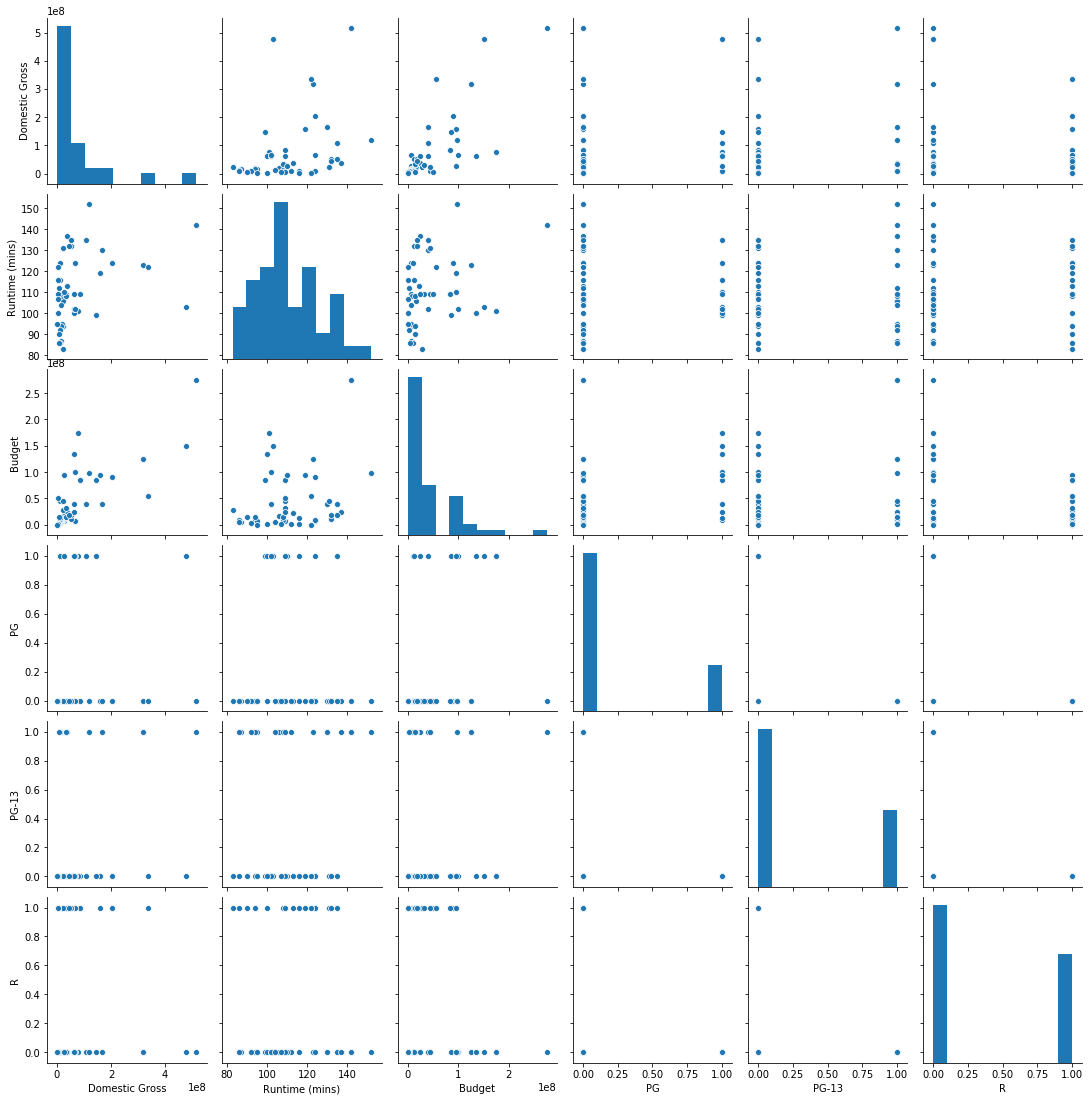

In [39]:
# sns.heatmap(df_ratings, vmin=-1, vmax=1)
sns.pairplot(df_ratings)

In [40]:
# query = "official trailer 2020"
# youtube_search = "https://www.youtube.com/results?search_query="
# youtube_query = youtube_search + query.replace(' ', '+')

# youtube_vid = "https://www.youtube.com/watch?v="
# vid_num = 'h4MUvlFmbi0'
# youtube_vid_num = youtube_vid + vid_num

# page = requests.get(youtube_vid_num).text
# soup = BeautifulSoup(page, 'html5lib')

# driver = webdriver.Chrome(chromedriver)
# driver.get(youtube_vid_num)

# driver.page_source[:1000]
# soup = BeautifulSoup(driver.page_source, 'html.parser')
# soup.find('div', id='contents')

In [41]:
# url = 'https://www.youtube.com/watch?v=-_DJEzZk2pc'
# response = requests.get(url)
# page = response.text

# driver = webdriver.Chrome(chromedriver)
# driver.get(url)

soup = BeautifulSoup(page, 'html5lib')
driver.page_source[:1000]
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [42]:
# url = 'https://www.youtube.com/watch?v=LiDDlaJYep8'
# response = requests.get(url)
# page = response.text

# driver = webdriver.Chrome(chromedriver)
# driver.get(url)

# soup = BeautifulSoup(page, 'html5lib')
# driver.page_source[:1000]
# soup = BeautifulSoup(driver.page_source, 'html.parser')

In [43]:
title_string = soup.find_all('h1', class_="title style-scope ytd-video-primary-info-renderer")

scrings = []

for title in title_string:
    scrings.append(title.text.split(' '))

scrings[0][0]

movie_dict = {}

m = re.search('\w+', scrings[0][0])
m.group(0)

movie_dict['Movie Title'] = m.group(0).capitalize()
movie_dict

{'Movie Title': 'Joker'}

In [44]:
views = soup.find('span', class_='view-count style-scope yt-view-count-renderer')

views_stripped = views.text.split(' ')[0]

new_views = ''

for char in views_stripped:
    if char != ',':
        new_views += char
        
views = int(new_views)
movie_dict['YT Trailer Views'] = views

In [45]:
view_df = pd.DataFrame.from_dict(movie_dict, orient='index')
view_df = view_df.T
view_df

,Movie Title,YT Trailer Views
0,Joker,24485816


In [53]:
df_new = view_df.merge(df_ratings, left_index=True, right_index=True)

In [54]:
df_new

,Movie Title_x,YT Trailer Views,Movie Title_y,Domestic Gross,Runtime (mins),Release Date,Budget,PG,PG-13,R
0,Joker,24485816,Bad Boys for Life,204417855,124,2020-01-17,90000000,0,0,1


In [55]:
df_ratings

,Movie Title,Domestic Gross,Runtime (mins),Release Date,Budget,PG,PG-13,R
0,Bad Boys for Life,204417855,124,2020-01-17,90000000,0,0,1
1,1917,159227644,119,2019-12-25,95000000,0,0,1
2,Sonic the Hedgehog,146066470,99,2020-02-14,85000000,1,0,0
3,Jumanji: The Next Level,316831246,123,2019-12-13,125000000,0,1,0
4,Star Wars: Episode IX,515202542,142,2019-12-20,275000000,0,1,0
5,Birds of Prey: And the Fantabulous Emancipatio...,84158461,109,2020-02-07,84500000,0,0,1
6,Dolittle,77047065,101,2020-01-17,175000000,1,0,0
7,Little Women,108101214,135,2019-12-25,40000000,1,0,0
8,The Invisible Man,64914050,124,2020-02-28,7000000,0,0,1
9,The Call of the Wild,62342368,100,2020-02-21,135000000,1,0,0


<Figure size 1440x1440 with 0 Axes>

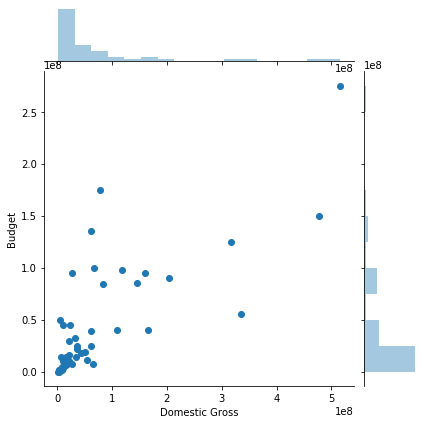

In [62]:
plt.figure(figsize=[20, 20])
sns.jointplot(df_ratings['Domestic Gross'], df_ratings['Budget']);

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [70]:
X = df_ratings.loc[df_ratings['domestic_total_gross'],
               df_ratings['runtime_minutes']]
y = df_ratings['Budget']

KeyError: 'domestic_total_gross'